## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
rows = text
text = (''.join(text)).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')


OK!


### Data loading: "Евгений Онегин"


In [4]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
#with open('onegin.txt', 'r', encoding='utf8') as iofile:
#    text = iofile.readlines()
    
#text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.
# Your great code here
# text = (''.join(text)).lower()


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))
tokens.append('|')

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
id_to_token = {token_to_idx[token] : token for token in tokens}

In [8]:
rows = [x.replace('\n', '') for x in rows]
rows = [x.lower() for x in rows]
MAX_LENGTH = max(map(len, rows))

In [9]:
import numpy as np

def to_matrix(rows, max_len=None, pad=token_to_idx['|'], dtype='int32', batch_first = True):    
    max_len = max_len or max(map(len, rows))
    rows_ix = np.zeros([len(rows), max_len], dtype) + pad

    for i in range(len(rows)):
        line_ix = [token_to_idx[c] for c in rows[i]]
        rows_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        rows_ix = np.transpose(rows_ix)

    return rows_ix

In [10]:
print('\n'.join(rows[::2000]))
print(to_matrix(rows[::2000]))

  from fairest creatures we desire increase,
  the ills that were not, grew to faults assur'd,
[[ 1  1 17 29 26 24  1 17 12 20 29 16 30 31  1 14 29 16 12 31 32 29 16 30
   1 34 16  1 15 16 30 20 29 16  1 20 25 14 29 16 12 30 16  6 38 38 38 38
  38]
 [ 1  1 31 19 16  1 20 23 23 30  1 31 19 12 31  1 34 16 29 16  1 25 26 31
   6  1 18 29 16 34  1 31 26  1 17 12 32 23 31 30  1 12 30 30 32 29  3 15
   6]]


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [12]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim= 1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [13]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss(ignore_index=token_to_idx['|'])
opt = torch.optim.Adam(char_rnn.parameters())
history = []
batch_size = 64
num_epoch = 3000

In [14]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [15]:
from matplotlib import pyplot as plt

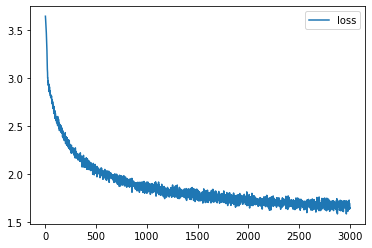

In [16]:
for i in range(num_epoch):
    batch_ix = to_matrix(sample(rows, batch_size), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1] #--log od probs of next tokens
    actual_next_tokens = batch_ix[:, 1:] #real tokens
    
    loss = criterion(
      predictions_logp.contiguous().view(-1, len(tokens)),
      actual_next_tokens.contiguous().view(-1)
    )
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [17]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens),p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [18]:
for _ in range(10):
    print(generate_sample(char_rnn))

  lof  so guboribs best nive, racs, in leise, a for tosk race,
    om my morew, sez.ongs, griend, ever doth of thee for moth 
  this hence a wowhen thy lives ill is worth, and ling, that n
    when i ofingpis, the vold; thou not do rice you, being thy
  me beass his wothouced outink, hath opts siven e furls, stad
  thy bode, pentllings, aprend.-so letueing mudstre swile by c
  your sadion, in thuch unfelded time chame, the lence i swart
  o! in my hour faiply where, what day tht hand enfeep,, and t
  xase theil ison grine wouldst me wold to swilith, sencerouss
  porthrous alliving ent, lexlimant taust the will ancomone is


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [19]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(num_units, num_tokens)
        
    def forward(self, x, hid_states=None):
        assert isinstance(x.data, torch.LongTensor)
        x_emb = self.emb(x)        
        if hid_states is None:
            hid_states = self.initial_state(1)
        h_seq, hid_states = self.lstm(self.emb(x), hid_states)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hid_states
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return (torch.zeros(1, batch_size, self.num_units, requires_grad=True),
                torch.zeros(1, batch_size, self.num_units, requires_grad=True))

In [20]:
model = CharLSTM()
opt = torch.optim.Adam(model.parameters())
history = []
criterion = nn.NLLLoss(ignore_index=token_to_idx['|'])
batch_size = 64
num_epoch = 3000

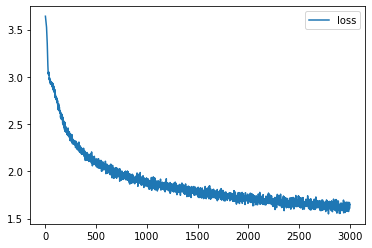

In [21]:
for i in range(num_epoch):
    batch_ix = to_matrix(sample(rows, batch_size), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq, hid_states = model(batch_ix, hid_states=model.initial_state(batch_size=batch_size))
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    loss = criterion(
      predictions_logp.contiguous().view(-1, len(tokens)),
      actual_next_tokens.contiguous().view(-1)
    )
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [22]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hid_state = model.initial_state(batch_size=1)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        _, hid_state = model(x_sequence[:, i].view(1, 1), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hid_state = model(x_sequence[:, -1].view(1, 1), hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next.ravel())
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [23]:
# Text generation with different temperature values here
temps = [0.1, 0.2, 0.5, 1.0, 2.0]

for t in temps:
    print(generate_sample(model, seed_phrase=' ', temperature=t))

  the self the self the self the self so the self shall the se
  the seet i have stay the pressing the self see i would steet
  is shall the me would in sellings thy love thee where where 
  knar rnonew-fhees of her'me goan fair say sudp of the vaid, 
  sarithon ner'fxins vabuwer'wle's with bhess thiscwo, ywyw-so


It seems that the best temperature is around 0.5, lower temperature model produces too many repeating words, higher temperature model generates non-existing words.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [24]:
torch.save(model.state_dict(), 'lstm.model')

In [25]:
model = CharLSTM()
model.load_state_dict(torch.load('lstm.model'))

<All keys matched successfully>

In [26]:
# Text generation with different temperature values here
temps = [0.1, 0.2, 0.5, 1.0, 2.0]

for t in temps:
    print(generate_sample(model, seed_phrase=' ', temperature=t))

  and the self the self the self the self the self the self th
  and the shall the shall the will the self so love the self m
    that in the self my worse were in the eyes of gress, liigh
  nor i lover! do of thine respine, 'is if time, selfanperno; 
 za  yk.telfed: i(f he my string alilx: aausks.ieg?; but;, ofl


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)